In [15]:
import torch
import numpy as np
from HPA_CC.models.train import find_checkpoint_file, CombinedModelLit
from HPA_CC.models.utils import combined_inference
from HPA_CC.data.dataset import RefCLSDM
from pathlib import Path
from config import HPA_DS_PATH
data_name = "minimal"
log_dirs_home = Path("/data/ishang/pseudotime_pred")

In [16]:
device = "cuda:0"
model_hashes = [
    "s41dnlu2", # soft without dropout
    "w4zfasnx", # hard with dropout
    # "rvvae90k", # hard with dropout, using image-level intensities, lol this one is ass
    "zb99ws39", # without intensities
    "llfsg1tc", # without intensities
    "27pjwaxg", # chamber only
    "mbco6uuv", # overview only
    "xhk2ann9", # tilescan only
    "xhnjriuf", # chamber only w smoothed pseudotime
    "ya6stucp", # overview only w smoothed pseudotime
    "lv2xkqjm", # tilescan only w smoothed pseudotime
]
repr_type = "hpa_dino", # "dino", "hpa_dino", or "conv"
ref_concat = True # for hpa_dino only, was this with concatenated cls tokens for each channel independently (default)
int_stats = [True, True, 
            #  False,
             False, False, False, False, False, False, False, False]
pseudo_preds, angle_preds, phase_preds = [], [], []
for model_hash, int_stat in zip(model_hashes, int_stats):
    print(model_hash)
    checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=False)
    combined_model = CombinedModelLit.load_from_checkpoint(checkpoint_file)
    combined_model.to(device)
    combined_model.eval()
    HPA_dm = RefCLSDM(HPA_DS_PATH, data_name, 32, 1, "all", inference=True, concat_well_stats=int_stat)
    pseudo_pred, angle_pred, phase_pred = combined_inference(combined_model, HPA_dm.inference_dataloader(), device, logits=True)
    pseudo_preds.append(pseudo_pred)
    angle_preds.append(angle_pred)
    phase_preds.append(phase_pred)
pseudo_preds = np.stack(pseudo_preds, axis=1)
angle_preds = np.stack(angle_preds, axis=1)
phase_preds = np.stack(phase_preds, axis=1)

s41dnlu2
Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/all_HPA-CC-dataset/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([1870, 1536])
X shape: torch.Size([1870, 2048])


/home/ishang/HPA_CC/src/HPA_CC/models/train.py:472: UserWarning: Soft and focal loss are both enabled, soft loss will be coerced into regular cross entropy loss
  warn("Soft and focal loss are both enabled, soft loss will be coerced into regular cross entropy loss")


w4zfasnx
Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/all_HPA-CC-dataset/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([1870, 1536])
X shape: torch.Size([1870, 2048])
zb99ws39
Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
X shape: torch.Size([1870, 1536])
llfsg1tc
Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
X shape: torch.Size([1870, 1536])
27pjwaxg
Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
X shape: torch.Size([1870, 1536])
mbco6uuv
Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
X shape: torch.Size([1870, 1536])
xhk2ann9
Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
X shape: torch.Size([1870, 1536])
xhnjriuf
Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
X shape: torch.Size([1870, 1536])
ya6stucp
Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_di

In [17]:
# phase_preds = np.concatenate([phase_preds, np.tile(np.arange(4), (phase_preds.shape[0], 1))], axis=1)
print(phase_preds.shape)

(1870, 10, 4)


(array([1045.,    0.,    0.,    0.,  246.,    0.,    0.,    0.,   33.,
           0.,    0.,  546.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  ]),
 <BarContainer object of 12 artists>)

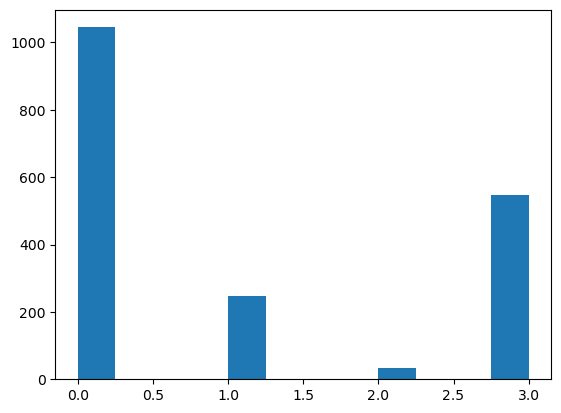

In [20]:
import matplotlib.pyplot as plt

# Get the counts of each class for each row
# counts = np.apply_along_axis(lambda x: np.max(np.bincount(x)), axis=1, arr=phase_preds)
model_dist = np.sum(phase_preds + 1e-5, axis=0)
def inverse_dist_weights(x):
    return np.sum(model_dist, axis=0) / model_dist[np.argmax(x, axis=1)]
weights = np.apply_along_axis
max_class = np.argmax(np.sum(phase_preds, axis=1), axis=1)
plt.hist(max_class, bins='auto')

# Plot the histogram
# plt.hist(counts, bins='auto')
# plt.title('Histogram of highest count for each row')
# plt.xlabel('Count')
# plt.ylabel('Frequency')
# plt.show()


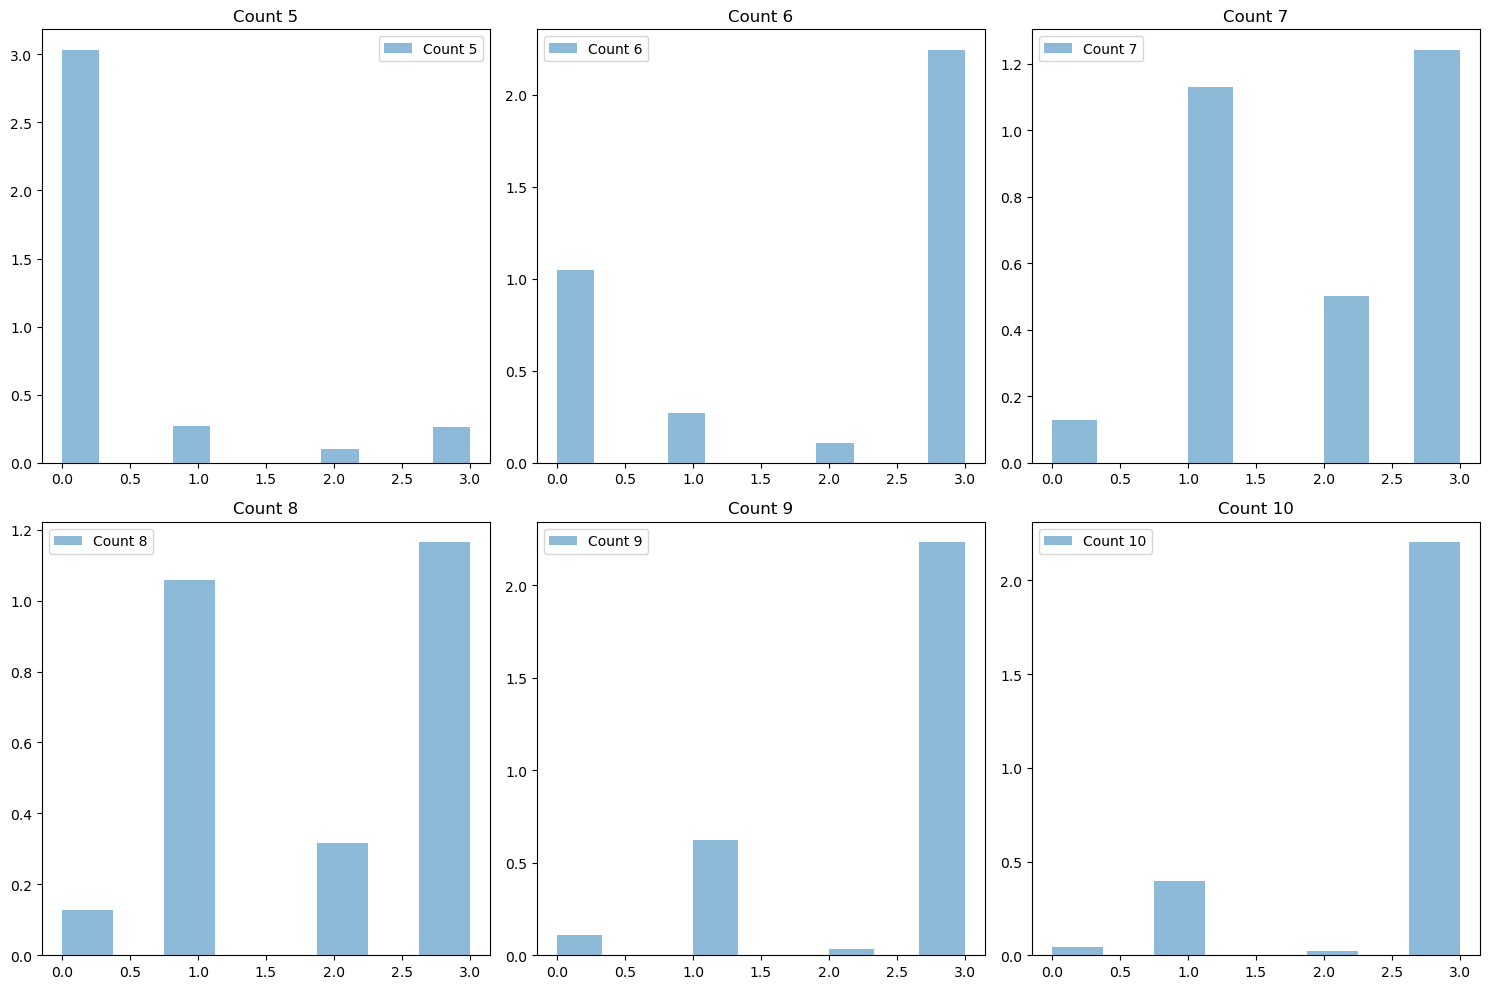

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10)) # Adjust the grid size and figure size as needed
axs = axs.ravel()

for i in range(max(counts)):
    if i < 5:
        continue
    ax = axs[i-5] # Subtract 5 because we are skipping the first 5
    classes = max_class[counts == i]
    ax.hist(classes, bins='auto', alpha=0.5, label=f"Count {i}", density=True)
    ax.legend()
    ax.set_title(f"Count {i}")

plt.tight_layout()
plt.show()
